# hex = 8 vs. Hex = 8
1. We need to label the cluster from hex = 8 to hex = 9
2. Using the centroid distance comparison


In [85]:
from sklearn.metrics.pairwise import euclidean_distances
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
import h3
from tqdm import tqdm
import seaborn as sns
# from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial import distance
import os
cluster_name_7 = {
    0: 'Open-view Connector',
    1: 'Urban Core - Enclosed',
    2: 'Natural Scene-a',
    3: 'Vegetated Community',
    4: 'Urban Core - Open',
    5: 'Diverse Urban Street',
    6: 'Natural Scene-b'
}

In [86]:
ROOTFOLDER = r"D:\Dropbox (Personal)\Personal Work\_Projects2023\01_city-never-was"
DATA_FOLDER = f"{ROOTFOLDER}/_data/_curated/c_seg_hex"
GRAPH_FOLDER = f"{ROOTFOLDER}/_graphic/_supplemental/_raw"
os.listdir(DATA_FOLDER)
# filename = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne_cluster_range.csv'
# df = pd.read_csv(f"{DATA_FOLDER}/{filename}")

['all_city_within_boundary_res=9_cluster=13.csv',
 'all_city_within_boundary_res=9_cluster=13.parquet',
 'all_city_within_boundary_res=9_cluster=8.csv',
 'all_city_within_boundary_res=9_cluster=8.parquet',
 'c_seg_cat=27_res=8.parquet',
 'c_seg_cat=27_res=8_withincity.parquet',
 'c_seg_cat=27_res=8_withincity_built_environment_tsne.parquet',
 'c_seg_cat=27_res=8_withincity_built_environment_tsne_cluster_range.csv',
 'c_seg_cat=27_res=8_withincity_tsne.parquet',
 'c_seg_cat=27_res=9.parquet',
 'c_seg_cat=27_res=9_withincity.parquet',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne.parquet',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_range.csv',
 'c_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_range_no_exposure_constrain.csv',
 'c_seg_cat=27_res=9_withincity_tsne.parquet',
 'c_seg_cat=27_res=9_withincity_tsne_cluster_range.csv',
 'robustness_city_cluster_mapping.csv',
 'robustness_h3_8.csv',
 'version_0717_test']

In [87]:
filename = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne_cluster_range.csv'
raw_file = 'c_seg_cat=27_res={res}_withincity_built_environment_tsne.parquet'
df_8 = pd.read_csv(f"{DATA_FOLDER}/{filename.format(res=8)}")
df_9 = pd.read_csv(f"{DATA_FOLDER}/{filename.format(res=9)}")

# df_8_raw = pd.read_parquet(f"{DATA_FOLDER}/{raw_file.format(res=8)}")
# df_9_raw = pd.read_parquet(f"{DATA_FOLDER}/{raw_file.format(res=9)}")
# df_8_raw.head()

,city_lower,hex_id,img_count,res,tsne_1,tsne_2
0,accra,8875292c81fffff,192,8.0,-26.529926,-26.847006
1,accra,8875292c83fffff,256,8.0,-9.774495,-62.520557
2,accra,8875292c85fffff,112,8.0,-26.428415,-26.569393
3,accra,8875292c87fffff,88,8.0,-10.518588,-65.302887
4,accra,8875292c89fffff,208,8.0,-26.535616,-26.880714


In [91]:
column_sel = 'cluster_7'
# df_8_raw_label = df_8_raw.merge(df_8[['hex_id', column_sel]], 
#                                 on='hex_id', how='inner')
# df_9_raw_label = df_9_raw.merge(df_9[['hex_id', column_sel]], 
#                                 on='hex_id', how='inner')
# df_9_raw_label.head()
# get the parent hex id for each level 9 hexes
df_9['hex_id_8'] = df_9['hex_id'].apply(lambda x: h3.h3_to_parent(x, 8))
df_9.head()
# vote the cluster_7 to get the most frequent cluster_7 for each level 8 hex
df_9_8 = df_9.groupby(['city_lower','hex_id_8', column_sel]).size().reset_index(name='count')
df_9_8 = df_9_8.sort_values(['city_lower','hex_id_8', 'count'], ascending=False).groupby('hex_id_8').head(1)
df_9_8.head()

,city_lower,hex_id_8,cluster_7,count
178913,zwolle,881f16d36dfffff,2,5
178912,zwolle,881f16d36bfffff,2,3
178910,zwolle,881f16d369fffff,0,1
178909,zwolle,881f16d367fffff,3,3
178906,zwolle,881f16d365fffff,2,2


In [94]:
df_9_8['cluster_7_name'] = df_9_8[column_sel].apply(lambda x: cluster_name_7[x])
df_9_8.groupby('cluster_7_name').size()

cluster_7_name
Diverse Urban Street      8072
Natural Scene-a          15598
Natural Scene-b          13336
Open-view Connector      14460
Urban Core - Enclosed     9774
Urban Core - Open         6917
Vegetated Community      11498
dtype: int64

In [127]:
df_9['cluster_7_name'] = df_9[column_sel].apply(lambda x: cluster_name_7[x])
df_9[['hex_id', 'cluster_7_name']].head()

,hex_id,cluster_7_name
0,8975292c127ffff,Open-view Connector
1,8975292c803ffff,Natural Scene-b
2,8975292c80bffff,Open-view Connector
3,8975292c817ffff,Open-view Connector
4,8975292c81bffff,Open-view Connector


In [128]:
df_9[['city_lower','hex_id', 'cluster_7_name']]\
    .to_csv(f"{DATA_FOLDER}/viz_seg_cat=27_res=9_withincity_built_environment_tsne_cluster_7.csv", index=False)

In [97]:
df_9_8.to_csv(os.path.join(DATA_FOLDER, 'c_seg_cat=27_res=8_withincity_built_environment_tsne_cluster=7_parent.csv'), index=False)

## revisualize the cluster attirbutes

In [ ]:
# load a city's data and visualize

In [119]:
variables_sel_top1_order = [
    'skyscraper',
 'light',
   
    "road",
 'sidewalk', 
  'traffic light', 
     # nature and open space
      "building",
     
    'window',
   
    'signage',
    'pole',
     'trashcan',
    'installation', 
     "railing",
    
    'shrub', 
    'grass',
    'tree',
    
     'mountain+hill',
    
    'sportsfield',
    'sky',
    'lake+waterboday',
]

In [121]:
# use these variables to compare the distance between cluster from level 8 to level 9
x_9 = df_9[variables_sel_top1_order+['hex_id', 'cluster_7']]
x_8 = df_8[variables_sel_top1_order+['hex_id', 'cluster_7']]
# for each cluster label in level 8, calculate the distance to each cluster in level 9
# and find the closest cluster
dist_matrix = {}
cluster_map_8_9 = {}
for i in range(7):
    for j in range(7):
        dist_matrix[(i,j)] = euclidean_distances(x_8[x_8['cluster_7']==i][variables_sel_top1_order],
                                                 x_9[x_9['cluster_7']==j][variables_sel_top1_order])
    # get the closest cluster
    cluster_map_8_9[i] = np.argmin([dist_matrix[(i,j)].mean() for j in range(7)])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [122]:
N = 7
def get_heat(df_8):
    df_summary = df_8[variables_sel_top1_order+[f"cluster_{N}"]].fillna(0).groupby(f"cluster_{N}").mean().stack().reset_index()\
    .rename(columns = {"level_1":"category", 0:"std_value"})
    df_summary_update = []
    for v in df_summary["category"].unique():
        temp = df_summary[df_summary["category"]==v].reset_index(drop = True)
        temp["norm_value"] = (temp["std_value"] - temp["std_value"].min())/(temp["std_value"].max() - temp["std_value"].min())
        df_summary_update.append(temp)
        
    df_summary_update = pd.concat(df_summary_update).reset_index()


    df_heat = df_summary_update.pivot(
        columns= "category", values = "norm_value", index = f"cluster_{N}"
    )[variables_sel_top1_order].sort_values(variables_sel_top1_order[:5], ascending = True)
    return df_heat
df_heat = get_heat(df_8)

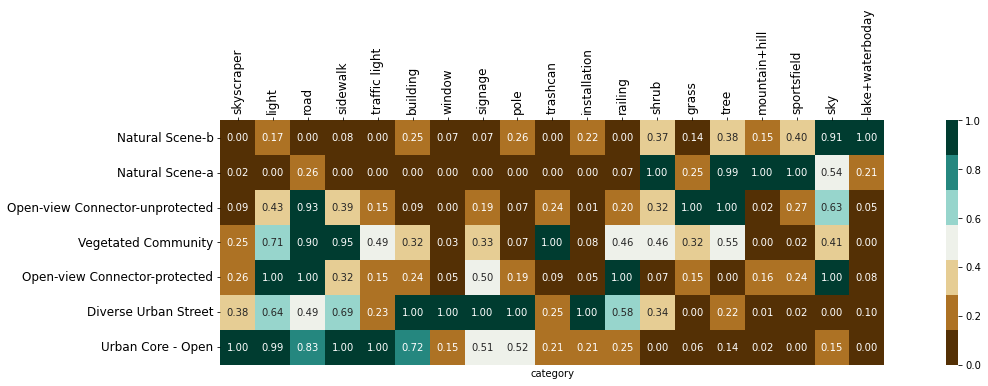

In [126]:
# use heatmap to visualize the cluster
fig, ax = plt.subplots(figsize = (22,4.5))
# use a gradient color
# cluster_order = [0,5,3,6,2,1,7,4]
# make a new linear cmap from #543005, #AD7224, #E6CD94, #EEF1EA, #97D5CC, #25877F, #003C30
h3_8_mapping = {
    4: 'Urban Core - Open',
    2: "Diverse Urban Street",
    0: 'Open-view Connector-protected',
    5: 'Vegetated Community',
    1: 'Open-view Connector-unprotected',
    6: 'Natural Scene-a',
    3: 'Natural Scene-b'
}
cmap = sns.color_palette(["#543005", "#AD7224", "#E6CD94", "#EEF1EA", "#97D5CC", "#25877F", "#003C30"])
sns.heatmap(df_heat, 
            cmap = cmap, annot = True, fmt=".2f",
            square = True, 
            ax = ax)
# show axis annotation larger
ax.tick_params(axis='both', which='major', labelsize=12)
# show ticks to the left
ax.yaxis.tick_left()
# show ticks to the bottom
ax.xaxis.tick_top()
# rotate the x axis
# relabel the y-ticks
ax.set_yticklabels([h3_8_mapping[i] for i in df_heat.index], rotation = 0)
# remove ylabel
ax.set_ylabel("")
plt.xticks(rotation=90)
fig.savefig(os.path.join(GRAPH_FOLDER, 'cluster_7_level_8.png'), bbox_inches = 'tight', dpi = 300)

In [133]:
h3_8_mapping = {
    4: 'Urban Core - Open',
    2: "Diverse Street",
    0: 'Open-view Connector-protected',
    5: 'Vegetated Community',
    1: 'Open-view Connector-unprotected',
    6: 'Natural Scene-a',
    3: 'Natural Scene-b'
}

In [134]:
# df_8['cluster_7_name'] = df_8['cluster_7'].apply(lambda x: h3_8_mapping[x])
# df_8[['city_lower', 
#       'hex_id',
#       'cluster_7',
#       'cluster_7_name'
#       ]].to_csv(os.path.join(DATA_FOLDER, 'viz_seg_cat=27_res=8_withincity_built_environment_tsne_cluster=7_child.csv'), index=False)

In [135]:
df_8['cluster_7_mapped'] = df_8['cluster_7'].map(h3_8_mapping)
df_8_city = df_8.groupby(['city_lower','cluster_7_mapped'])['hex_id'].count().unstack().fillna(0)
df_8_city['robustness_type'] = 'h3'
# convert the cluster_7_mapped to proportion
for col in df_8_city.columns[:-1]:
    df_8_city[col] = df_8_city[col]/df_8_city[col].sum()

df_8_city.to_csv(os.path.join(DATA_FOLDER, 'robustness_h3_8.csv'), index=True)

In [136]:
df_8_city.columns

Index(['Diverse Street', 'Natural Scene-a', 'Natural Scene-b',
       'Open-view Connector-protected', 'Open-view Connector-unprotected',
       'Urban Core - Open', 'Vegetated Community', 'robustness_type'],
      dtype='object', name='cluster_7_mapped')

os.listdir(DATA_FOLDER)